In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#d94801','white','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['white','gray']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cma=custom_cmap

colors = ['#ccece6','#99d8c9','#66c2a4','#41ae76','#238b45','#006d2c']
cml = sns.blend_palette(colors, n_colors=256, as_cmap=True)

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

## arrange data
#female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
#female_df = female_df[keep_syllables]

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)

In [6]:
# use only common ages
f_ages = f_df.index.get_level_values('age').unique().to_numpy()
m_ages = m_df.index.get_level_values('age').unique().to_numpy()
cages = list(np.intersect1d(f_ages,m_ages))
    
m_data = m_df.loc[m_df.index.get_level_values('age').isin(cages)]
m_data['sex'] = 'm'
m_data.set_index('sex',inplace=True,append=True)

f_data = f_df.loc[f_df.index.get_level_values('age').isin(cages)]
f_data['sex'] = 'f'
f_data.set_index('sex',inplace=True,append=True)

data=pd.concat([m_data,f_data])

/tmp/ipykernel_25391/1557580464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m_data['sex'] = 'm'
/tmp/ipykernel_25391/1557580464.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['sex'] = 'f'


In [7]:
#average and normalize male
avg_m_df = m_data.groupby(['age']).mean()
# normalize the data
m_norm = mm_norm_col(m_data)
avg_m_norm = mm_norm_col(avg_m_df)

#average and normalize female
avg_f_df = f_data.groupby(['age']).mean()
# normalize the data
f_norm = mm_norm_col(f_data)
avg_f_norm = mm_norm_col(avg_f_df)

data=pd.concat([m_data,f_data])

In [8]:
data=pd.concat([m_norm,f_norm])
df=data.copy()
pc = PCA(n_components=2)
pcss = pc.fit_transform(df)

In [9]:
pcs = pd.DataFrame(pcss, columns=['PC1','PC2'])
pcs['sex'] = df.index.get_level_values('sex')
pcs['age'] = df.index.get_level_values('age')

spcs = pcs.sample(frac=1).reset_index(drop=True)

In [10]:
variance_explained = pc.explained_variance_ratio_
# Calculate cumulative variance explained by PCs
cumulative_variance_explained = np.cumsum(variance_explained)
print(cumulative_variance_explained)

[0.18152919 0.32084542]


In [11]:
format_plots()

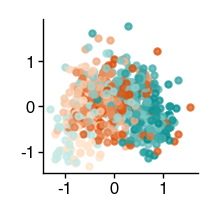

In [12]:
norm = plt.Normalize(vmin=4, vmax=90)
mask = spcs['sex'] == "m"
c = cmm(norm(spcs.loc[mask, 'age']))
spcs.loc[mask, 'color'] = [str(tuple(x)) for x in c]
mask = spcs['sex'] == "f"
c2 = cmf(norm(spcs.loc[mask, 'age']))
spcs.loc[mask, 'color'] = [str(tuple(x)) for x in c2]
fig, ax = plt.subplots()
fig.set_size_inches(1,1) 
for ind, row in spcs.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color=eval(row['color']),s=5, alpha=0.75)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'fvm_pca_fit_on_both_shuffled.pdf')

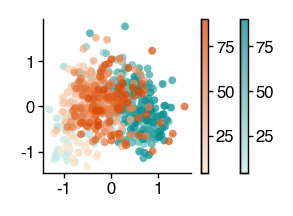

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(1.5,1) 
im = plt.scatter(x=pcs.query("sex=='m'")['PC1'], y=pcs.query("sex=='m'")['PC2'], 
                cmap=cmm,
                s=8,
                edgecolor='none',
                c=pcs.query("sex=='m'")['age'], 
                linewidth=0.25,
                #norm='log',
            alpha=0.75,
               )
cb=fig.colorbar(im,ax=ax)
im2=plt.scatter(x=pcs.query("sex=='f'")['PC1'], y=pcs.query("sex=='f'")['PC2'], 
                cmap=cmf,
                s=8,
                edgecolor='none',
                c=pcs.query("sex=='f'")['age'], 
                linewidth=0.25,
                #norm='log',
                alpha=0.75,
               )
cb=fig.colorbar(im2,ax=ax)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ 'fvm_pca_fit_on_both.pdf')